### Модель машинного обучения для выявления токсичных комментариев с точностью не менее 90%.

In [1]:
'''Подключим необходимые библиотеки'''

import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79609\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
'''Создадим датафрейм. Данные для модели были взяты с 
https://www.kaggle.com/blackmoon/russian-language-toxic-comments?select=labeled.csv'''

df = pd.read_csv("labeled.csv", sep=",")

In [3]:
'''Датафрейм имеет размерность:'''

df.shape

(14412, 2)

In [4]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
'''Переведем значения из столбца "Toxic" из float в int'''

df["toxic"] = df["toxic"].apply(int)

In [6]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [7]:
'''Определим количество количество комментариев по классам, где "0"- нейтральный комментарий,
а "1"- оскорбительный комментарий'''

df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [8]:
'''Примеры "токсичных" комментариев'''

for c in df[df["toxic"] == 1]["comment"].head(5):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [9]:
'''Примеры комментариев, отмеченных как неоскорбительные'''

for c in df[df["toxic"] == 0]["comment"].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [10]:
'''Разделим датафрейм на тренировочную и тестовую выборки'''

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

In [11]:
test_df.shape

(4324, 2)

In [12]:
test_df["toxic"].value_counts()

0    2906
1    1418
Name: toxic, dtype: int64

In [13]:
train_df["toxic"].value_counts()

0    6680
1    3408
Name: toxic, dtype: int64

Соотношение классов примерно соответствует соотношению в датафрейме df.

In [14]:
'''Преобразум текст каждого комментария в вектор, убрав знаки пунктуации и стоп-слова, а также применим стемминг'''

snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [15]:
sentence_example = df.iloc[1]["comment"]

tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [16]:
'''Применим TF-IDF векторизацию'''

vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [17]:
'''Обучим полученную модель'''

features = vectorizer.fit_transform(train_df["comment"])

model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(random_state=0)

In [18]:
'''Проверим полученную модель'''

model.predict(features[0])

array([0], dtype=int64)

In [19]:
train_df["comment"].iloc[0]

'Вышел покурить на балкон, а тут Ын курит. Постояли, покурили.\n'

Предсказанный класс действительно оказался токсичным.

In [20]:
'''Создадим конвейер для обработки комментариев с применением модели'''

model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))])

In [21]:
'''Обучим конвейер'''

model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001E2F34B6A60>)),
                ('model', LogisticRegression(random_state=0))])

In [22]:
'''Вычислим точнсть предсказаний модели'''

precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.8936605316973415

In [23]:
'''Вычислим полноту предсказаний модели'''

recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.616361071932299

In [24]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

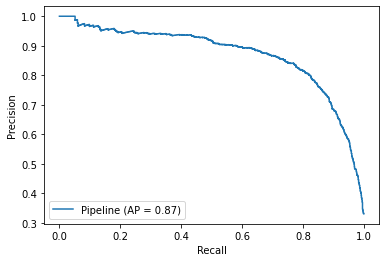

In [25]:
'''Визуализируем полученные метрики'''

plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

In [26]:
'''Определим порог, при котором точность модели выше 90%'''

np.where(prec > 0.9)

(array([3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368,
        3369, 3370, 3371, 3372, 3373, 3377, 3378, 3379, 3380, 3381, 3382,
        3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393,
        3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404,
        3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415,
        3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426,
        3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437,
        3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448,
        3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459,
        3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470,
        3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481,
        3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492,
        3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503,
        3504, 3505, 3506, 3507, 3508, 

In [27]:
thresholds[3358]

0.5183315113973129

In [28]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[3358])

0.9005464480874317

In [29]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[3358])

0.5811001410437235

In [30]:
'''Попробуем подобрать оптимальные гиперпараметр логистической регресси (коэффициент регуляризации),
добавив в pipeline GridSearch'''

grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [31]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.676, total=   0.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................... C=0.1, score=0.672, total=   0.2s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.672, total=   0.1s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV] ................................. C=1, score=0.829, total=   0.4s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.825, total=   0.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.815, total=   0.4s
[CV] C=10.0 ..........................................................


C:\Users\79609\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............................. C=10.0, score=0.854, total=   0.6s
[CV] C=10.0 ..........................................................


C:\Users\79609\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] .............................. C=10.0, score=0.861, total=   0.5s
[CV] C=10.0 ..........................................................


C:\Users\79609\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    3.2s finished


[CV] .............................. C=10.0, score=0.861, total=   0.6s


C:\Users\79609\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001E2F3D2E3A0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

Наилучший показатель был достигнут при С=10.

In [32]:
'''Создадим новую модель со значением регуляризации равным 10'''

model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))])

In [33]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

C:\Users\79609\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001E2F4368310>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [34]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [35]:
np.where(prec_c_10 > 0.90)

(array([3309, 3310, 3311, 3312, 3316, 3317, 3318, 3319, 3320, 3321, 3322,
        3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333,
        3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344,
        3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355,
        3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366,
        3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377,
        3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388,
        3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399,
        3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410,
        3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421,
        3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432,
        3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443,
        3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454,
        3455, 3456, 3457, 3458, 3459, 

In [36]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[3309])

0.9003147953830011

In [37]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[3309])

0.6050775740479548